# Geometric Positioning of InSAR Points

@author: Max Felius

## Hypothesis
The retrieval of sinkhole parameters can be improved by a better spreading of the measurement points.
- A better spreading of points will lead to a lower conditional number of the design matrix.
- A better spreading will lead to a higher fitting percentage and a lower RMSE.

## Predictions (better articulate this part...)
- Higher fit will be accompanied with a lower conditional number (well-conditioned vs ill-conditioned).
- Less points will provide a worse fit.
- Points on a line or spread out on a 2D plane won't affect the fit and conditional number.
- The further the points away from the center, the worse the fit will be.
- Very heterogenous points will provide a worse fit
- The more points with the same radius will give worse fit

## Design the experiment
- Define sinkhole using kinematic model
- Define inverse model to retrieve parameters
- Define tool to create point samples
- Generate seperate cases for each prediction and answer that prediction

In [1]:
#imports
import numpy as np
import matplotlib.pyplot as plt
import random
import os,sys,time

In [173]:
# random.uniform(0, 1)
# nums = np.random.uniform(0, 1, size=1000)
# 1/550**2

3.305785123966942e-06

In [315]:
#kinematic model 
#automatically introduce some noise into the system
def zg(R,r):
    return (1/(R*R))*np.exp(-np.pi*(r**2/R**2))
def zg_nois(R,r):
    noise_tune = 0.5
    return (1/(R*R))*np.exp(-np.pi*(r**2/R**2)) + (noise_tune*(1/(R*R))*np.random.uniform(0,1,size=len(r)))

In [167]:
# r = np.array([1,2,4,6,8,12,44,77,88,99,200,300,250,500,550])
# R = 550

# print(zg(R,r))

[3.30575079e-06 3.30564780e-06 3.30523586e-06 3.30454940e-06
 3.30358861e-06 3.30084501e-06 3.23998211e-06 3.10837097e-06
 3.05032832e-06 2.98585578e-06 2.18203252e-06 1.29820855e-06
 1.72734338e-06 2.46428457e-07 1.42855928e-07]


In [186]:
#defining the inverse model
def inverse_kinematic_model(v,t,R,r,y):
    '''
    Non-Linear Least Squares for determining kinematic model parameters
    
    Input:
    :type v: int
    :type t: np.array(float)
    :type R: int
    :type r: np.array(float)
    :type y: np.array(float)
    
    Output
    :rtype R: int
    :rtype v: int
    '''
    #maximum number of runs
    n = 10000
    
    #initial values
    Qyy = np.eye(len(r))
    invQyy = np.linalg.inv(Qyy)
    
    #start the timer
    start = time.time()
    
    for i in range(n):
        #expected deformation
        yhat = v*t*zg(R,r)
        
        #compute the difference in measured and computed subsidence
        dy = y - yhat
        
        #defining the jacobian matrix
        A1 = t*zg(R,r)
        A2 = ((2*R**2 + 2*np.pi*r**2)/(R**3))*(v*t)*zg(R,r)
           
        J = np.array([A1,A2]).T
        
        cond_number = np.linalg.cond(J)
        
        Qxhat = np.linalg.inv(J.T @ invQyy @ J)
        dx = Qxhat @ J.T @ invQyy @ dy
        
        v_old = v
        R_old = R
        v = v + dx[0]
        R = R + dx[1]
        
        dx_hat = np.array([v_old-v,R_old-R]).T
        
        if dx_hat.T @ Qxhat @ dx_hat < sys.float_info.epsilon:
#             print(f'Stopped at iteration {i+1}.\nThe computed values are v={v} and R={R}.')
            break
    
#     if i == n-1:
#         print(f'Ended using the maximum number of iterations: {n}.\nThe computed values are v={v} and R={R}.')
    
#     print(f'The total runtime was: {time.time()-start} seconds.')
    
    return v, R, i, cond_number

In [32]:
#Create cell to make point samples
#using the sinkhole from wink2016 for generating the point samples
v_wink2016_gaus = 95.78920335026163
R_wink2016_gaus = 553.0609564207195
delta_days = np.array([0, 12, 24, 36, 48, 60, 72, 96, 108, 120, 132])

#coordinates
x0 = 25
y0 = 25

#Define the sinkhole grid
n = 100
x_range = R_wink2016_gaus
y_range = R_wink2016_gaus
x = np.linspace(x0-x_range/2,x0+x_range/2,n)
y = np.linspace(y0-y_range/2,y0+y_range/2,n)

#creat x/y grid
xv, yv = np.meshgrid(x,y)

#unravel the grids
x_unravel = xv.ravel()
y_unravel = yv.ravel()

In [92]:
'''
Example of how to create subsamples
'''
#example 1
def get_random_subsamples(n_sub,x_unravel,y_unravel):
# n_sub = 30
    idx = random.sample(range(0,len(x_unravel)),int(n_sub))
    
    #subsampling the arrays
    x_sub = x_unravel[idx]
    y_sub = y_unravel[idx]
    
    return x_sub, y_sub

In [181]:
def get_subsampled_arrays(x_sub,y_sub,r,delta_days):
    #create row arrays for x,y,z containing every epoch
    x_array = np.array([])
    y_array = np.array([])
    z_array = np.array([])
    t = np.array([])
    r_array = np.array([])

    nitems = 0
    for step in delta_days:
        n = len(x_sub)
        x_array = np.concatenate((x_array,x_sub))
        y_array = np.concatenate((y_array,y_sub))
        z_array = np.concatenate((z_array,step*v_wink2016_gaus*zg_nois(R_wink2016_gaus,r)))
        t = np.concatenate((t,[delta_days[nitems]]*n))
        r_array = np.concatenate((r_array,r))
        nitems += 1
    
    return x_array, y_array, z_array, t, r_array, nitems

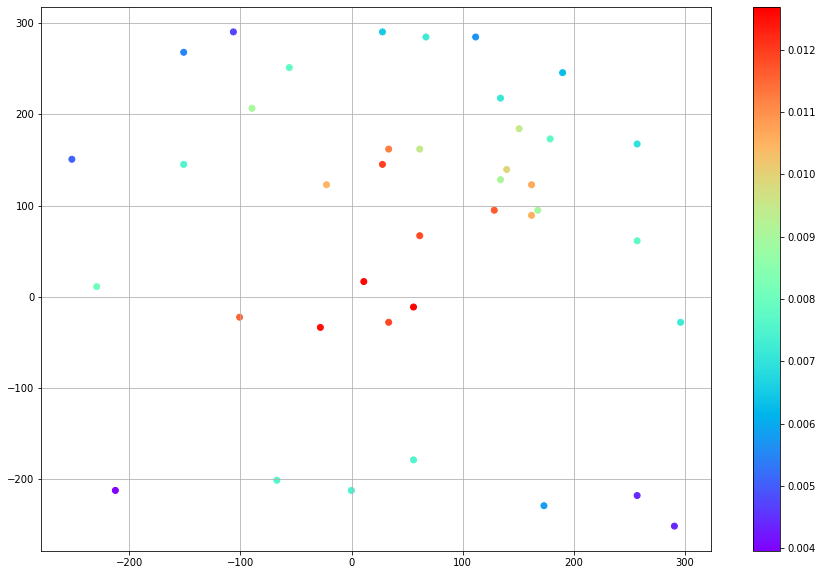

In [216]:
n_sub = 40

x_sub, y_sub = get_random_subsamples(n_sub,x_unravel,y_unravel)

#compute the radius
r = np.sqrt((x_sub-x0)**2 + (y_sub-y0)**2)

x_array, y_array, z_array, t, r_array, nitems = get_subsampled_arrays(x_sub,y_sub,r,delta_days)

fig, axs = plt.subplots(nrows=1,ncols=1, figsize=(15,10))
i = 3
h = axs.scatter(x_sub,y_sub,c=z_array[i*n_sub:n_sub+i*n_sub],cmap=plt.cm.rainbow)
plt.grid(True)
fig.colorbar(h);

In [130]:
number_subs = [x for x in range(1,100)]

#coordinates of center point to be evaluated
x0 = 25
y0 = 25

#Time vector is days
delta_days = np.array([0, 12, 24, 36, 48, 60, 72, 96, 108, 120, 132])

#save variables
cond_saved = []
iter_saved = []

for n_sub in number_subs:
    x_sub, y_sub = get_random_subsamples(n_sub,x_unravel,y_unravel)

    #compute the radius
    r = np.sqrt((x_sub-x0)**2 + (y_sub-y0)**2)

    x_array, y_array, z_array, t, r_array, nitems = get_subsampled_arrays(x_sub,y_sub,r,delta_days)

    #initial parameters
    R = 500
    v = 100
    
    #catch singular matrices
    try:
        v, R, i, cond_number = inverse_kinematic_model(v,t,R,r_array,z_array)
    except:
        cond_number = np.nan
        i = np.nan
    
    #save variables
    cond_saved.append(cond_number)
    iter_saved.append(i)

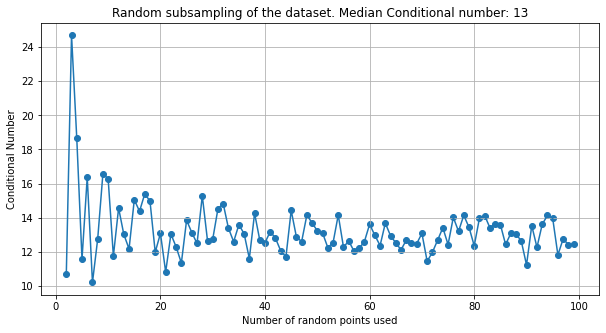

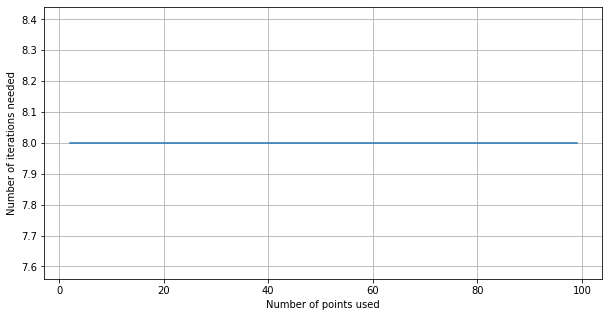

In [131]:
plt.figure(figsize=(10,5))
plt.plot(number_subs,cond_saved)
plt.scatter(number_subs,cond_saved)

#mean of the conditional number. SKIPPED THE FIRST ENTRY
mean = np.median(cond_saved[1:])

plt.title('Random subsampling of the dataset. Median Conditional number: {:.0f}'.format(mean))
plt.ylabel('Conditional Number')
plt.xlabel('Number of random points used')

plt.grid(True);

plt.figure(figsize=(10,5))
plt.plot(number_subs,iter_saved)

plt.ylabel('Number of iterations needed')
plt.xlabel('Number of points used')

plt.grid(True);

## Seperate Cases (Predictions)
- Case 1: Higher fit will be accompanied with a lower conditional number (well-conditioned vs ill-conditioned).
- Case 2: Less points will provide a worse fit.
- Case 3: Points on a line or spread out on a 2D plane won't affect the fit and conditional number.
- Case 4: The further the points away from the center, the worse the fit will be.
- Case 5: Very heterogenous points will provide a worse fit
- Case 6: The more points with the same radius will give worse fit

### Case 1

Higher model fit will be accompanied with a lower conditional number (well-conditioned vs ill-conditioned).

- Define inverse model to retrieve model fit (extract ehat and z data)
- Test assumption: More points will increase the model fit

In [182]:
#defining the inverse model for case 1 and 2
def case_inverse_kinematic_model(v,t,R,r,y):
    '''
    Non-Linear Least Squares for determining kinematic model parameters
    
    Input:
    :type v: int
    :type t: np.array(float)
    :type R: int
    :type r: np.array(float)
    :type y: np.array(float)
    
    Output
    :rtype R: int
    :rtype v: int
    '''
    #maximum number of runs
    n = 10000
    
    #initial values
    Qyy = np.eye(len(r))
    invQyy = np.linalg.inv(Qyy)
    
    #start the timer
    start = time.time()
    
    for i in range(n):
        #expected deformation
        yhat = v*t*zg(R,r)
        
        #compute the difference in measured and computed subsidence
        dy = y - yhat
        
        #defining the jacobian matrix
        A1 = t*zg(R,r)
        A2 = ((2*R**2 + 2*np.pi*r**2)/(R**3))*(v*t)*zg(R,r)
           
        J = np.array([A1,A2]).T
        
        cond_number = np.linalg.cond(J)
        
        Qxhat = np.linalg.inv(J.T @ invQyy @ J)
        dx = Qxhat @ J.T @ invQyy @ dy
        
        v_old = v
        R_old = R
        v = v + dx[0]
        R = R + dx[1]
        
        dx_hat = np.array([v_old-v,R_old-R]).T
        
        if dx_hat.T @ Qxhat @ dx_hat < sys.float_info.epsilon:
#             print(f'Stopped at iteration {i+1}.\nThe computed values are v={v} and R={R}.')
            break
    
#     if i == n-1:
#         print(f'Ended using the maximum number of iterations: {n}.\nThe computed values are v={v} and R={R}.')
    
#     print(f'The total runtime was: {time.time()-start} seconds.')
    
    ehat = yhat - y
    
    return ehat, y

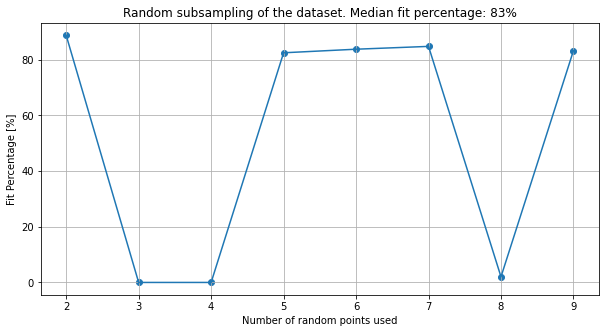

In [325]:
number_subs = [x for x in range(1,10)]

#coordinates of center point to be evaluated
x0 = 25
y0 = 25

#Time vector is days
delta_days = np.array([0, 12, 24, 36, 48, 60, 72, 96, 108, 120, 132])

#save variables
ehat_saved = []
y_saved = []
fit_saved = []

for n_sub in number_subs:
    x_sub, y_sub = get_random_subsamples(n_sub,x_unravel,y_unravel)

    #compute the radius
    r = np.sqrt((x_sub-x0)**2 + (y_sub-y0)**2)

    x_array, y_array, z_array, t, r_array, nitems = get_subsampled_arrays(x_sub,y_sub,r,delta_days)

    #initial parameters
    R = 500
    v = 100
    
    #catch singular matrices
    try:
        ehat, y = case_inverse_kinematic_model(v,t,R,r_array,z_array)
        
        fit = 100*(1-(np.sum(abs(ehat))/np.sum(abs(y))))
    except:
        ehat = np.nan
        y = np.nan
        fit = np.nan
    
    #save variables
    ehat_saved.append(ehat)
    y_saved.append(y)
    fit_saved.append(fit)

    
#Plot the results
plt.figure(figsize=(10,5))
plt.plot(number_subs,fit_saved)
plt.scatter(number_subs,fit_saved)

#mean of the conditional number. SKIPPED THE FIRST ENTRY
mean = np.median(fit_saved[1:])

plt.title('Random subsampling of the dataset. Median fit percentage: {:.0f}%'.format(mean))
plt.ylabel('Fit Percentage [%]')
plt.xlabel('Number of random points used')

plt.grid(True);

# plt.figure(figsize=(10,5))
# plt.plot(number_subs,iter_saved)

# plt.ylabel('Number of iterations needed')
# plt.xlabel('Number of points used')

# plt.grid(True);

### Case 2

Less points will provide a worse fit.

### Case 3

Points on a line or spread out on a 2D plane won't affect the fit and conditional number.

### Case 4

The further the points away from the center, the worse the fit will be.

### Case 5

Very heterogenous points will provide a worse fit.

### Case 6

The more points with the same radius will give worse fit.